
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [16]:
## library imports here
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from plotnine import *
from sklearn.metrics import f1_score, roc_auc_score
import warnings

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [3]:
# Check data types
ha.dtypes

age        int64
sex        int64
cp         int64
trtbps     int64
chol       int64
restecg    int64
thalach    int64
output     int64
dtype: object

In [4]:
# Convert variables that should be categorical to categorical
ha["sex"] = ha["sex"].astype(str)
ha["cp"] = ha["cp"].astype(str)
ha["restecg"] = ha["restecg"].astype(str)
ha["output"] = ha["output"].astype(str)

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [5]:
# Define X and y
y = ha["cp"]
X = ha.drop("cp", axis=1)

In [6]:
# Fit multiclass KNN
warnings.filterwarnings("ignore", category=UserWarning)

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(drop="first", sparse_output = False, handle_unknown="ignore"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

knn_classification_pipeline = Pipeline(
  [("preprocessing", ct),
  ("knn_classification", KNeighborsClassifier())]
)

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {"knn_classification__n_neighbors": range(1, 101)}
gscv = GridSearchCV(knn_classification_pipeline, param_grid, scoring="roc_auc_ovo", cv=stratified_cv)
gscv.fit(X, y)

print(f"Best k: {gscv.best_params_}")
print(f"Best ROC AUC: {gscv.best_score_}")

Best k: {'knn_classification__n_neighbors': 82}
Best ROC AUC: 0.667327268728004
Best k: {'knn_classification__n_neighbors': 82}
Best ROC AUC: 0.667327268728004


In [7]:
knn_classification_pipeline = Pipeline(
  [("preprocessing", ct),
  ("knn_classification", KNeighborsClassifier(n_neighbors=82))]
)

knn_fit = knn_classification_pipeline.fit(X, y)

In [28]:
# Fit multiclass Decision Tree

dt_classification_pipeline = Pipeline(
    [("dt_classification", DecisionTreeClassifier(random_state=42))]
)

param_grid = {
    "dt_classification__max_depth": range(0, 11, 1),
    "dt_classification__min_impurity_decrease": [0.0, 0.001, 0.01, 0.1],
    "dt_classification__min_samples_leaf": range(0, 11, 1),
    "dt_classification__ccp_alpha": [0.0, 0.01, 0.1, 1.0]
}

gscv = GridSearchCV(dt_classification_pipeline, param_grid, cv=stratified_cv, scoring="roc_auc_ovo")
gscv.fit(X, y)

print("Best hyperparameters:", gscv.best_params_)
print(f"Best ROC AUC: {gscv.best_score_}")

Best hyperparameters: {'dt_classification__ccp_alpha': 0.01, 'dt_classification__max_depth': 3, 'dt_classification__min_impurity_decrease': 0.0, 'dt_classification__min_samples_leaf': 1}
Best ROC AUC: 0.6693727794536619
Best hyperparameters: {'dt_classification__ccp_alpha': 0.01, 'dt_classification__max_depth': 3, 'dt_classification__min_impurity_decrease': 0.0, 'dt_classification__min_samples_leaf': 1}
Best ROC AUC: 0.6693727794536619


/Users/megangibson/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1680 fits failed out of a total of 9680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
880 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/megangibson/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/megangibson/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/megangibson/anaconda3/lib/python3.11/site-packages/skl

In [33]:
dt_classification_pipeline = Pipeline(
    [("dt_classification", DecisionTreeClassifier(ccp_alpha=0.01, max_depth=3, min_samples_leaf=1, random_state=42))]
)

dt_fit = dt_classification_pipeline.fit(X, y)

In [10]:
# Fit multiclass LDA
lda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lda", LinearDiscriminantAnalysis())])


lda_fit = lda_pipeline.fit(X, y)
y_numeric = y.astype(int)
lda_preds = lda_fit.predict_proba(X)
roc_auc_score(y_numeric, lda_preds, multi_class="ovo")

0.7288690215231014

[Text(0.4, 0.875, 'output <= 0.5\ngini = 0.661\nsamples = 273\nvalue = [128, 44, 81, 20]'),
 Text(0.2, 0.625, 'gini = 0.425\nsamples = 127\nvalue = [94, 8, 18, 7]'),
 Text(0.6, 0.625, 'trtbps <= 143.5\ngini = 0.691\nsamples = 146\nvalue = [34, 36, 63, 13]'),
 Text(0.4, 0.375, 'thalach <= 152.5\ngini = 0.674\nsamples = 122\nvalue = [31, 34, 52, 5]'),
 Text(0.2, 0.125, 'gini = 0.641\nsamples = 40\nvalue = [17, 5, 16, 2]'),
 Text(0.6, 0.125, 'gini = 0.652\nsamples = 82\nvalue = [14, 29, 36, 3]'),
 Text(0.8, 0.375, 'gini = 0.656\nsamples = 24\nvalue = [3, 2, 11, 8]')]

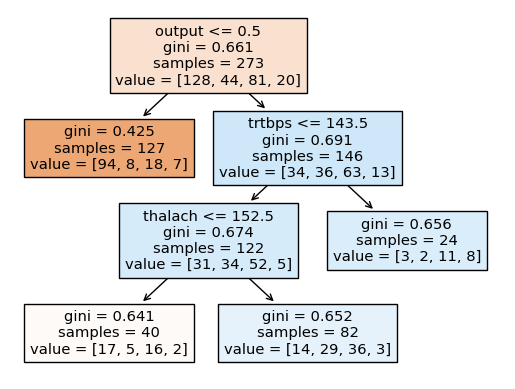

In [34]:
# Make decision tree plot
dt_model = dt_fit.named_steps["dt_classification"]
feature_names = X.columns.tolist()
plot_tree(dt_model, feature_names=feature_names, filled=True)



The first split occurs on the `output` variable. If `output==0`, then it's most likely that the patient has the `cp` type of 0, meaning they are asymptomatic (94 out of 127 samples). This makes sense because if a patient has no symptoms of a heart attack, it's less likely that they are having one. If `output==1`, then 63 of the 146 patients in the sample had type 2 chest pain, 34 were asymptomatic, 36 had type 1, and 13 had type 3. If `output==1`, the next split occurs on the `trtbps` variable, a continuous variable representing blood pressure. If `trtbps` is less than or equal to 143.5, which is true for the vast majority of patients in the sample (122 out of 146), then the most common target class is `cp==2` (at 52 out of 122). For the few who had blood pressure greater than 143.5, `cp==2` and `cp==3` were the most common chest pain classes (at 11 and 8 out of 24, respectively). 



## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [39]:
# Define function that returns 1 where cp is 3 and 0 otherwise
def cp_is_3(x):
  if x == "3":
    return 1
  else:
    return 0

# Create new variable applying this function
ha["cp_is_3"] = ha["cp"].apply(cp_is_3)

In [40]:
# Fit logistic regression model with this new target in mind
y = ha["cp_is_3"]
X = ha[["age", "sex", "trtbps", "chol", "restecg", "thalach", "output"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

log_reg_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log_reg", LogisticRegression(random_state=42))]
)

log_reg_fit = log_reg_pipeline.fit(X_train, y_train)
log_reg_preds = log_reg_fit.predict(X_test)

f1_score(y_test, log_reg_preds)

0.0

In [41]:
# Define function that returns 1 where cp is 0 and 0 otherwise
def cp_is_0(x):
  if x == "0":
    return 1
  else:
    return 0

ha["cp_is_0"] = ha["cp"].apply(cp_is_0)

In [42]:
# Fit logistic regression model with this new target in mind
y = ha["cp_is_0"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

log_reg_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log_reg", LogisticRegression(random_state=42))]
)

log_reg_fit = log_reg_pipeline.fit(X_train, y_train)
log_reg_preds = log_reg_fit.predict(X_test)

f1_score(y_test, log_reg_preds)

0.75

In [43]:
# Define function that returns 1 where cp is 1 and 0 otherwise
def cp_is_1(x):
  if x == "1":
    return 1
  else:
    return 0

ha["cp_is_1"] = ha["cp"].apply(cp_is_1)

In [44]:
# Fit logistic regression model with this new target in mind
y = ha["cp_is_1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

llog_reg_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log_reg", LogisticRegression(random_state=42))]
)

log_reg_fit = log_reg_pipeline.fit(X_train, y_train)
log_reg_preds = log_reg_fit.predict(X_test)

f1_score(y_test, log_reg_preds)

0.0

In [45]:
# Define function that returns 1 where cp is 2 and 0 otherwise
def cp_is_2(x):
  if x == "2":
    return 1
  else:
    return 0

ha["cp_is_2"] = ha["cp"].apply(cp_is_2)

In [46]:
# Fit logistic regression model with this new target in mind
y = ha["cp_is_2"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

log_reg_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log_reg", LogisticRegression(random_state=42))]
)

log_reg_fit = log_reg_pipeline.fit(X_train, y_train)
log_reg_preds = log_reg_fit.predict(X_test)

f1_score(y_test, log_reg_preds)

0.10526315789473684



The OvR approach was best at distinguishing between **`cp==0` and the others**, having the highest F1-score of 0.75.



## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [47]:
# Create new dataset with only the 0 and 1 types of chest pain
ha_new = ha[(ha["cp"] == "0") | (ha["cp"] == "1")]

In [48]:
# Fit logistic regression on dataset with 0 and 1 types of cp
y = ha_new["cp"]
X = ha_new[["age", "sex", "trtbps", "chol", "restecg", "thalach", "output"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

log_reg_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log_reg", LogisticRegression(random_state=42))]
)

log_reg_fit = log_reg_pipeline.fit(X_train, y_train)
log_reg_preds = log_reg_fit.predict(X_test)

# Get ROC-AUC score
roc_auc_score(y_test, log_reg_preds)

0.6623931623931624

In [49]:
# Create new dataset with only the 0 and 2 types of chest pain
ha_new_2 = ha[(ha["cp"] == "0") | (ha["cp"] == "2")]

In [50]:
# Fit logistic regression on dataset with 0 and 2 types of cp
y = ha_new_2["cp"]
X = ha_new_2[["age", "sex", "trtbps", "chol", "restecg", "thalach", "output"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

log_reg_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log_reg", LogisticRegression(random_state=42))]
)

log_reg_fit = log_reg_pipeline.fit(X_train, y_train)
log_reg_preds = log_reg_fit.predict(X_test)

# Get ROC-AUC score
roc_auc_score(y_test, log_reg_preds)

0.8028846153846155

In [51]:
# Create new dataset with only the 0 and 3 types of chest pain
ha_new_3 = ha[(ha["cp"] == "0") | (ha["cp"] == "3")]

In [52]:
# Fit logistic regression on dataset with 0 and 3 types of cp
y = ha_new_3["cp"]
X = ha_new_3[["age", "sex", "trtbps", "chol", "restecg", "thalach", "output"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

log_reg_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log_reg", LogisticRegression(random_state=42))]
)

log_reg_fit = log_reg_pipeline.fit(X_train, y_train)
log_reg_preds = log_reg_fit.predict(X_test)

# Get ROC-AUC score
roc_auc_score(y_test, log_reg_preds)

0.6057692307692307



The OvO approach was most able to distinguish between **`cp==0` and `cp==2`**. This pair had the highest ROC-AUC score of roughly 0.8.

